Copyright (C) 2023 Ming-Fong Sie <seansie07@gmail.com> & Yu-Jing Lin <elvisyjlin@gmail.com>

This work is licensed under the Creative Commons Attribution-NonCommercial
4.0 International License. To view a copy of this license, visit
http://creativecommons.org/licenses/by-nc/4.0/ or send a letter to
Creative Commons, PO Box 1866, Mountain View, CA 94042, USA.

#### Some Abbreviations
1. cm: confusion matrix
2. rp: classification report
3. fi: feature importance
4. if: important features

Average confusion matrix of training set in 10-fold


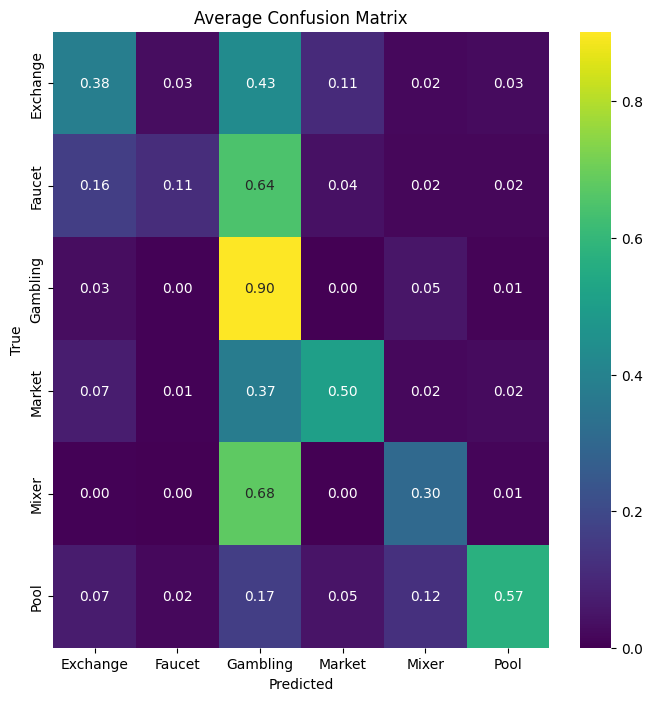

Average confusion matrix of validation set in 10-fold


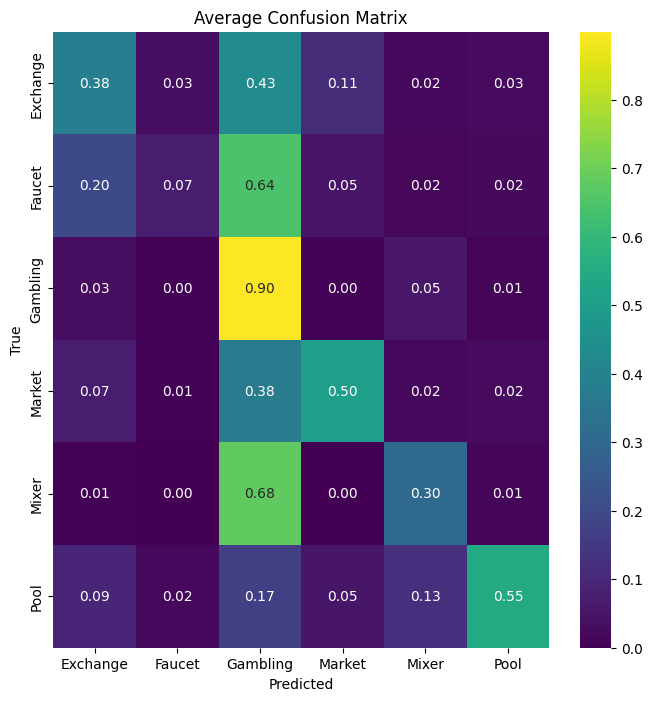

Average classification report of validation set in 10-fold


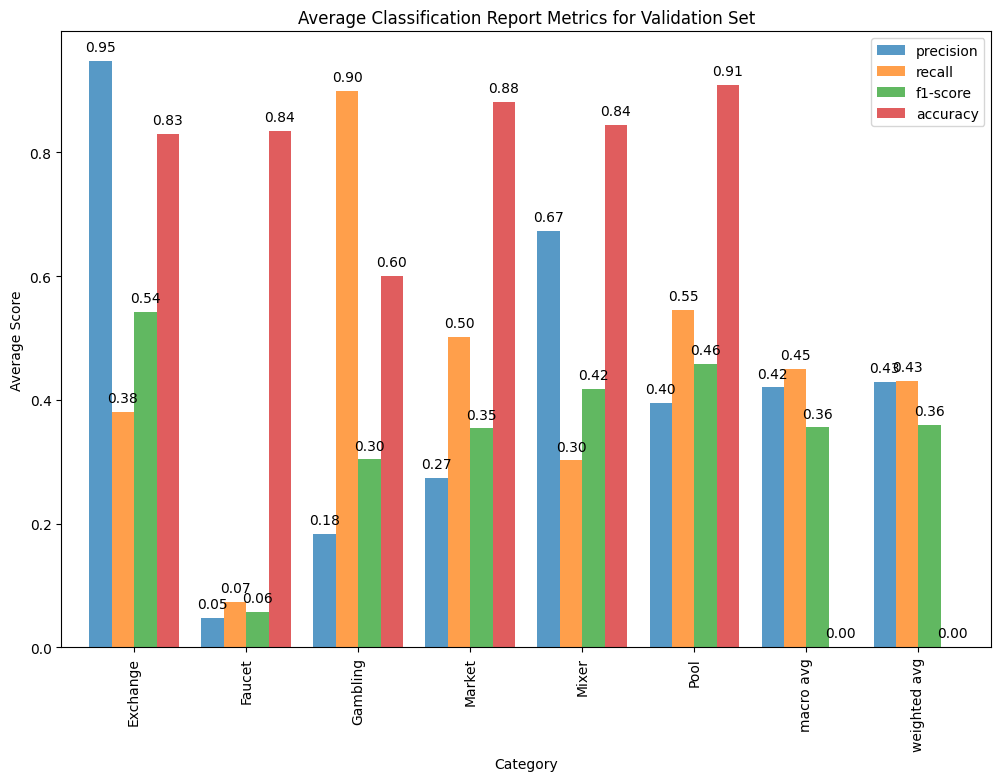

In [1]:
import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# 定義讀取結果的函數
def load_results(result_path, model_name, feature_type, scheme, cost_sensitive=False):
    experiment_name = os.path.join(result_path, '{}.{}.{}'.format(model_name, feature_type, scheme))
    # if not cost_sensitive:
    #     experiment_name += '.no_cs'
    results_path = experiment_name + '.pkl'
    
    with open(results_path, 'rb') as file:
        results = pickle.load(file)
    
    return results, experiment_name

# 定義顯示混淆矩陣列表的函數
def show_cm_list(cm_list, class_names):
    avg_cm = np.mean(cm_list, axis=0)
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(avg_cm, annot=True, fmt='.2f', cmap='viridis', xticklabels=class_names, yticklabels=class_names, ax=ax)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Average Confusion Matrix')
    plt.show()

# 定義顯示分類報告和準確率的函數
def show_rp_list_and_accuracies(rp_list, cm_list, class_names):
    class_names_list = list(class_names)  # Convert class_names to a list for index access
    summed_metrics, avg_metrics = {}, {}
    summed_category_accuracies = {category: 0 for category in class_names}
    summed_accuracy = 0

    for report in rp_list:
        for category, metrics in report.items():
            if category == 'accuracy':
                summed_accuracy += metrics
                continue

            if category in class_names_list and isinstance(metrics, dict):
                if category not in summed_metrics:
                    summed_metrics[category] = {key: 0 for key in metrics if key != 'support'}
                for metric, value in metrics.items():
                    if metric != 'support':
                        summed_metrics[category][metric] += value

    for cm in cm_list:
        for i, category in enumerate(class_names_list):
            if category in summed_metrics:  # Ensure category exists in the metrics dictionary
                TP = cm[i, i]
                TN = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - TP)
                FP = cm[:, i].sum() - TP
                FN = cm[i, :].sum() - TP
                accuracy = (TP + TN) / float(TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
                summed_category_accuracies[category] += accuracy

    # Calculate average metrics and accuracies
    for category in class_names_list:
        if category in summed_metrics:
            avg_metrics[category] = {metric: summed_metrics[category][metric] / len(rp_list) for metric in ['precision', 'recall', 'f1-score']}
    
    # Calculate macro and weighted averages
    macro_avg = {metric: sum(avg_metrics[cat][metric] for cat in class_names_list) / len(class_names_list) for metric in ['precision', 'recall', 'f1-score']}
    weighted_avg = {metric: sum(avg_metrics[cat][metric] * summed_category_accuracies[cat] for cat in class_names_list) / sum(summed_category_accuracies.values()) for metric in ['precision', 'recall', 'f1-score']}
    
    # Append macro and weighted averages to avg_metrics
    avg_metrics['macro avg'] = macro_avg
    avg_metrics['weighted avg'] = weighted_avg

    avg_accuracy = summed_accuracy / len(rp_list) if len(rp_list) > 0 else 0
    avg_category_accuracies = {category: summed_category_accuracies[category] / len(cm_list) for category in class_names_list}

    return avg_metrics, avg_category_accuracies, avg_accuracy

# 指定相關參數並繪製圖表
result_path = 'result/'  # 替換為你的結果路徑
model_name = 'svm'         # 替換為你的模型名稱
feature_type = 'bem'     # 替換為你的特徵類型
scheme = 'address'            # 替換為你的方案
class_names = ['Exchange', 'Faucet', 'Gambling', 'Market', 'Mixer', 'Pool']  # 替換為你的分類名稱
n_folds = 10  # 替換為你的交叉驗證折數

# 載入結果
results, experiment_name = load_results(result_path, model_name, feature_type, scheme)

# 顯示訓練集的平均混淆矩陣
print('Average confusion matrix of training set in {:d}-fold'.format(n_folds))
show_cm_list(results['train_cm_list'], class_names)

# 顯示驗證集的平均混淆矩陣
print('Average confusion matrix of validation set in {:d}-fold'.format(n_folds))
show_cm_list(results['valid_cm_list'], class_names)

# 顯示驗證集的平均分類報告和準確率
print('Average classification report of validation set in {:d}-fold'.format(n_folds))
avg_metrics, avg_category_accuracies, avg_accuracy = show_rp_list_and_accuracies(results['valid_rp_list'], results['valid_cm_list'], class_names)

df_averages = pd.DataFrame(avg_metrics).T
df_averages['accuracy'] = pd.Series(avg_category_accuracies)

ax = df_averages.plot(kind='bar', figsize=(12, 8), width=0.8, alpha=0.75)
ax.set_title('Average Classification Report Metrics for Validation Set')
ax.set_ylabel('Average Score')
ax.set_xlabel('Category')
ax.legend(loc='upper right')

for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()


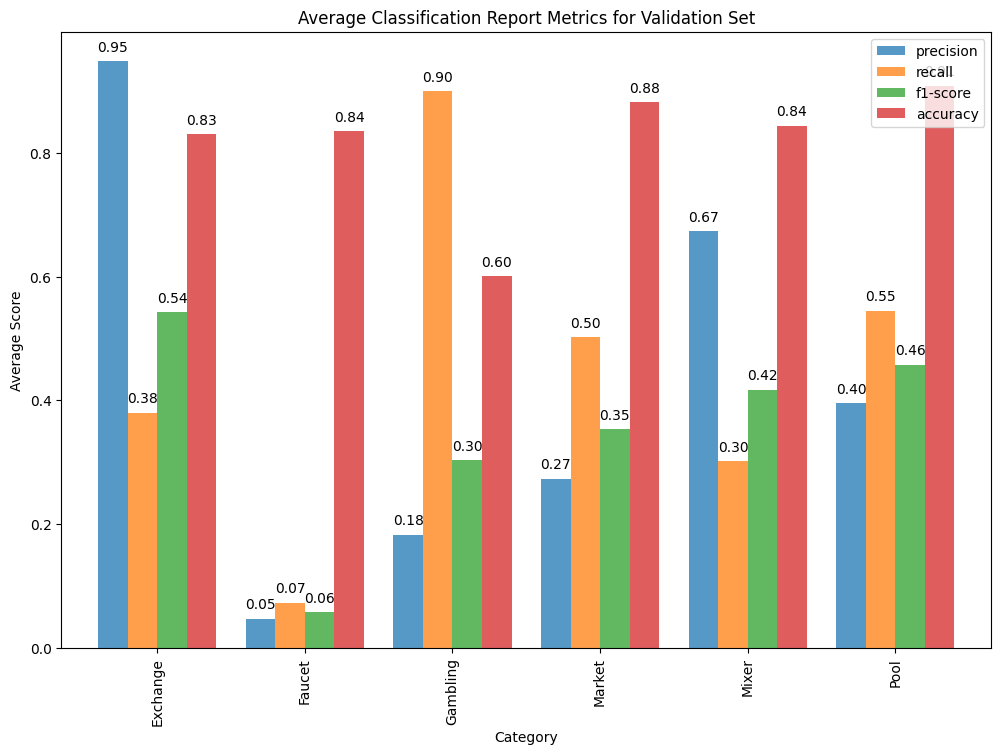

In [2]:
# 定義顯示分類報告和準確率的函數
def show_rp_list_and_accuracies(rp_list, cm_list, class_names):
    # Initialize dictionaries for summed and average metrics
    summed_metrics, avg_metrics = {}, {}
    summed_category_accuracies, avg_category_accuracies = {}, {}
    summed_accuracy = 0

    # Initialize summed metrics and accuracies
    for category in class_names:
        summed_metrics[category] = {'precision': 0, 'recall': 0, 'f1-score': 0}
        summed_category_accuracies[category] = 0

    # Iterate over reports and confusion matrices
    for report_index, report in enumerate(rp_list):
        for category, metrics in report.items():
            # Skip 'accuracy', 'macro avg', and 'weighted avg' categories
            if category in ['accuracy', 'macro avg', 'weighted avg']:
                if category == 'accuracy':
                    summed_accuracy += metrics
                continue

            # Sum metrics for each category
            for metric in ['precision', 'recall', 'f1-score']:
                if metric in metrics:
                    summed_metrics[category][metric] += metrics[metric]

        # Calculate and sum category-specific accuracies
        cm = cm_list[report_index]
        for i, category in enumerate(class_names):
            TP = cm[i, i]
            TN = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - TP)
            FP = cm[:, i].sum() - TP
            FN = cm[i, :].sum() - TP
            accuracy = (TP + TN) / float(TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
            summed_category_accuracies[category] += accuracy

    # Calculate average metrics and accuracies
    for category in class_names:
        avg_metrics[category] = {metric: value / len(rp_list) for metric, value in summed_metrics[category].items()}
        avg_category_accuracies[category] = summed_category_accuracies[category] / len(cm_list)
    avg_accuracy = summed_accuracy / len(rp_list)

    # Return average metrics and accuracies
    return avg_metrics, avg_category_accuracies, avg_accuracy

# 使用該函數來計算驗證集的平均分類報告和準確率
avg_metrics, avg_category_accuracies, avg_accuracy = show_rp_list_and_accuracies(results['valid_rp_list'], results['valid_cm_list'], class_names)

# 準備繪製的 DataFrame
df_averages = pd.DataFrame(avg_metrics).T
df_averages['accuracy'] = pd.Series(avg_category_accuracies)

# 繪製條形圖
ax = df_averages.plot(kind='bar', figsize=(12, 8), width=0.8, alpha=0.75)
ax.set_title('Average Classification Report Metrics for Validation Set')
ax.set_ylabel('Average Score')
ax.set_xlabel('Category')
ax.legend(loc='upper right')

# 為每個條形圖添加數值標籤
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()


In [3]:
# # 定義特徵
# basic = [
#     'f_tx', 'f_received', 'f_coinbase',
#     'f_spent_digits_-3', 'f_spent_digits_-2', 'f_spent_digits_-1', 'f_spent_digits_0',
#     'f_spent_digits_1', 'f_spent_digits_2', 'f_spent_digits_3', 'f_spent_digits_4',
#     'f_spent_digits_5', 'f_spent_digits_6', 'f_received_digits_-3', 'f_received_digits_-2',
#     'f_received_digits_-1', 'f_received_digits_0', 'f_received_digits_1', 'f_received_digits_2',
#     'f_received_digits_3', 'f_received_digits_4', 'f_received_digits_5', 'f_received_digits_6',
#     'r_payback', 'n_inputs_in_spent', 'n_outputs_in_spent'
# ]
# extra = [
#     'n_tx', 'total_days', 'n_spent', 'n_received', 'n_coinbase', 'n_payback',
#     'total_spent_btc', 'total_received_btc',
#     'total_spent_usd', 'total_received_usd',
#     'mean_balance_btc', 'std_balance_btc',
#     'mean_balance_usd', 'std_balance_usd'
# ]
# moments = [
#     'interval_1st_moment', 'interval_2nd_moment', 'interval_3rd_moment', 'interval_4th_moment',
#     'dist_total_1st_moment', 'dist_total_2nd_moment', 'dist_total_3rd_moment', 'dist_total_4th_moment',
#     'dist_coinbase_1st_moment', 'dist_coinbase_2nd_moment', 'dist_coinbase_3rd_moment', 'dist_coinbase_4th_moment',
#     'dist_spend_1st_moment', 'dist_spend_2nd_moment', 'dist_spend_3rd_moment', 'dist_spend_4th_moment',
#     'dist_receive_1st_moment', 'dist_receive_2nd_moment', 'dist_receive_3rd_moment', 'dist_receive_4th_moment',
#     'dist_payback_1st_moment', 'dist_payback_2nd_moment', 'dist_payback_3rd_moment', 'dist_payback_4th_moment'
# ]
# patterns =[
#     'tx_input', 'tx_output',
#     'n_multi_in', 'n_multi_out', 'n_multi_in_out'
# ]

# features = []
# if not feature_type.startswith('if') and len(feature_type) > 0:
#     if 'b' in feature_type:
#         features += basic
#     if 'e' in feature_type:
#         features += extra
#     if 'm' in feature_type:
#         features += moments
#     if 'p' in feature_type:
#         features += patterns
# elif feature_type.startswith('if') and feature_type[2:].isdigit():
#     all_features = basic + extra + moments + patterns
#     if_indices = [
#         0, 25, 24, 29, 40, 37, 27, 23, 56, 36,
#         1, 28, 26, 57, 32, 38, 44, 45, 33, 18,
#         39, 60, 53, 35, 34, 52, 41, 17, 14, 15,
#         16, 19, 42, 5, 6, 47, 7, 46, 2, 54,
#         4, 43, 8, 59, 58, 55, 9, 13, 61, 48,
#         3, 31, 10, 62, 20, 21, 63, 30, 49, 11,
#         51, 50, 22, 12
#     ]
#     if_features = [all_features[i] for i in if_indices]
#     n_if = int(feature_type[2:])
#     features = if_features[:n_if]
# else:
#     raise Exception('Invalid feature types: {:s}'.format(feature_type))


# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd
# import numpy as np

# # 確保有特徵重要性數據
# if len(results['fi_list']) == 0:
#     raise ValueError("No feature importance data found.")

# # 計算平均特徵重要性
# fi_avg = np.mean(results['fi_list'], axis=0)

# # 打印特徵重要性的排序
# print(fi_avg.argsort()[::-1])

# # 準備特徵重要性數據的 DataFrame
# df_feature_importances = pd.DataFrame({'name': features, 'importance': fi_avg})

# # 選取前10個重要特徵
# df_top_10 = df_feature_importances.nlargest(10, columns='importance')

# # 繪製特徵重要性條形圖
# plt.figure(figsize=(10, 8))
# sns.barplot(x='importance', y='name', data=df_top_10)
# plt.title('Top 10 Feature Importances')
# plt.xlabel('Importance')
# plt.ylabel('Feature Name')
# plt.show()


[[0.3802173  0.03014536 0.43188329 0.10926452 0.02103663 0.02745289]
 [0.19706834 0.0731582  0.64490767 0.04582144 0.01756139 0.02148296]
 [0.03097974 0.00477586 0.89944353 0.00361424 0.0530536  0.00813303]
 [0.07284977 0.00571892 0.37518055 0.50199437 0.01939249 0.02486389]
 [0.00591868 0.00108382 0.67864373 0.         0.3021821  0.01217167]
 [0.09156986 0.02097593 0.16521455 0.05060178 0.12634485 0.54529304]]


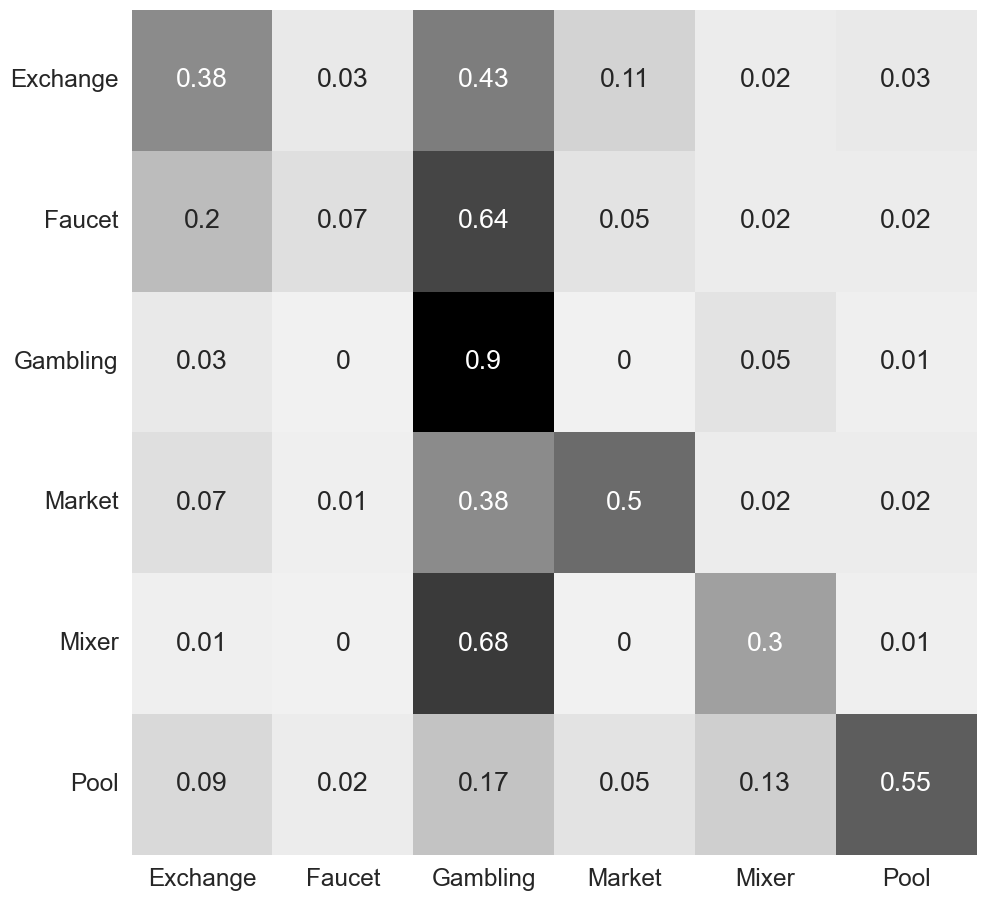

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.colors import ListedColormap

# 計算驗證集的平均混淆矩陣
cm_avg = np.mean(results['valid_cm_list'], axis=0)

# 打印平均混淆矩陣
print(cm_avg)

# 確保在Jupyter Notebook中運行
def run_from_ipython():
    try:
        __IPYTHON__
        return True
    except NameError:
        return False

if run_from_ipython():
    # 準備數據框
    df_cm = pd.DataFrame(cm_avg, index=class_names, columns=class_names)
    
    # 設置圖表大小
    plt.figure(figsize=(10, 10))
    
    # 使用輕色調的配色方案
    cmap = sns.light_palette('black', as_cmap=True)
    
    # 設置字體比例
    sns.set(font_scale=1.6)
    
    # 繪製熱力圖
    sns.heatmap(df_cm.round(2), annot=True, square=True, cbar=False, cmap=cmap)
    
    # 設置x和y軸標籤的旋轉角度
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    
    # 恢復字體比例
    sns.set(font_scale=1)
    
    # 自動調整圖表佈局
    plt.tight_layout()
    
    # 顯示圖表
    plt.show()
    # 保存圖表到文件（如果需要保存，取消下面這行的註釋）
    # plt.savefig('confusion_matrix.png')


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# 確保在前面的程式碼中已經計算了以下變數
# train_cm_list, valid_cm_list, train_auc_list, valid_auc_list

# 計算平均混淆矩陣
avg_train_cm = np.mean(results['train_cm_list'], axis=0)
avg_valid_cm = np.mean(results['valid_cm_list'], axis=0)

# 計算平均AUC分數
avg_train_auc = np.mean(results['train_auc_list'])
avg_valid_auc = np.mean(results['valid_auc_list'])

# 展示平均混淆矩陣
print("Average Training Confusion Matrix:")
print(avg_train_cm)
print("\nAverage Validation Confusion Matrix:")
print(avg_valid_cm)

# 展示平均AUC分數
print(f"\nAverage Train AUC: {avg_train_auc}")
print(f"Average Valid AUC: {avg_valid_auc}")

# 繪製AUC分數圖表
plt.figure(figsize=(10, 6))
plt.plot(results['train_auc_list'], label='Train AUC', marker='o')
plt.plot([avg_train_auc] * len(results['train_auc_list']), 'r--', label='Average Train AUC')
plt.plot(results['valid_auc_list'], label='Valid AUC', marker='o')
plt.plot([avg_valid_auc] * len(results['valid_auc_list']), 'g--', label='Average Valid AUC')
plt.title('AUC Scores per Fold')
plt.xlabel('Fold Number')
plt.ylabel('AUC Score')
plt.legend()
plt.show()


KeyError: 'train_auc_list'

In [6]:
from sklearn.metrics import roc_auc_score

# 初始化AUC分數列表
train_auc_list = []
valid_auc_list = []

# Cross-validation loop
for train_idx, valid_idx in tqdm(skf.split(X, y)):
    X_train, X_valid = X[train_idx], X[valid_idx]
    y_train, y_valid = y[train_idx], y[valid_idx]
    
    clf = get_model(model, clf_params)
    clf.fit(X_train, y_train)
    
    y_train_pred_proba = clf.predict_proba(X_train)
    y_valid_pred_proba = clf.predict_proba(X_valid)
    
    train_auc = roc_auc_score(y_train, y_train_pred_proba, multi_class='ovr')
    valid_auc = roc_auc_score(y_valid, y_valid_pred_proba, multi_class='ovr')
    
    train_auc_list.append(train_auc)
    valid_auc_list.append(valid_auc)


NameError: name 'tqdm' is not defined